In [1]:
def remove_outliers_iqr(df, columns=None, factor=1.5):
    
    if columns is None:
        columns = df.columns
    
    # Ensure the specified columns are in the DataFrame
    columns = [col for col in columns if col in df.columns]
    
    # Calculate Q1, Q3, and IQR for the specified columns
    Q1 = df[columns].quantile(0.25)
    Q3 = df[columns].quantile(0.75)
    IQR = Q3 - Q1

    # Calculate lower and upper bounds
    lower_bounds = Q1 - factor * IQR
    upper_bounds = Q3 + factor * IQR
    
    # Create a mask to identify rows with values within bounds
    mask = np.all((df[columns] >= lower_bounds) & (df[columns] <= upper_bounds), axis=1)
    
    # Return the DataFrame with rows containing outliers removed
    return df[mask]

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

# Read the DataFrame from the Parquet file
df = pd.read_parquet('numbikesavailable.parquet')

print(df.isna().sum())

df = df.set_index('record_timestamp').sort_index()
df.info()


,total_bikes
count,34952.000000
mean,17345.851511
std,1319.559790
min,296.000000
25%,16655.000000
50%,17503.000000
75%,18363.000000
max,36736.000000


record_timestamp    0
total_bikes         0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34952 entries, 2024-06-02 18:37:00.476000+00:00 to 2024-07-29 00:57:00.443000+00:00
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   total_bikes  34952 non-null  float64
dtypes: float64(1)
memory usage: 546.1 KB


In [48]:
df = remove_outliers_iqr(df)
display(df.describe())

,total_bikes
count,34219.000000
mean,17422.039510
std,1194.080374
min,14093.000000
25%,16719.000000
50%,17531.000000
75%,18382.000000
max,20633.000000


In [4]:
assert df['total_bikes'].isna().sum() == 0, "There are NaNs in the original data"


<Axes: title={'center': 'Total bikes docked'}, xlabel='record_timestamp'>

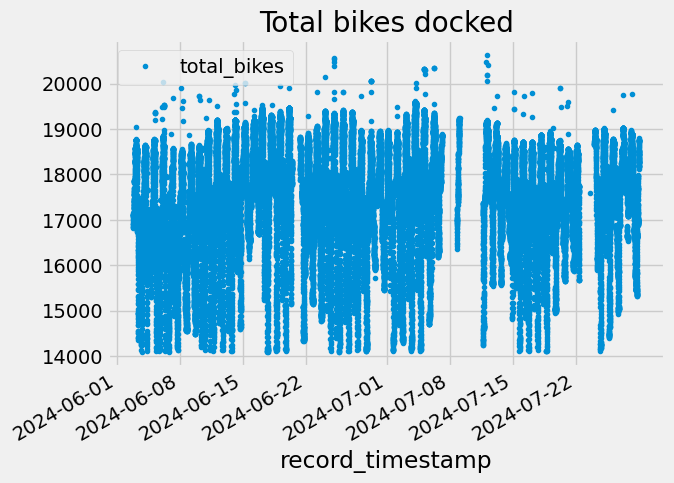

In [5]:
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
df.plot(style='.', title='Total bikes docked')

In [6]:
# Train test split
cutoff_date = '2024-07-15'

train = df.loc[df.index < cutoff_date ]
train = train.dropna(axis=0)

test = df.loc[df.index >= cutoff_date]
test = test.dropna(axis=1)
train.shape, test.shape

((25576, 1), (8643, 1))

In [7]:
train.shape, test.shape

((25576, 1), (8643, 1))

In [8]:
display(test.isna().sum())

total_bikes    0
dtype: int64

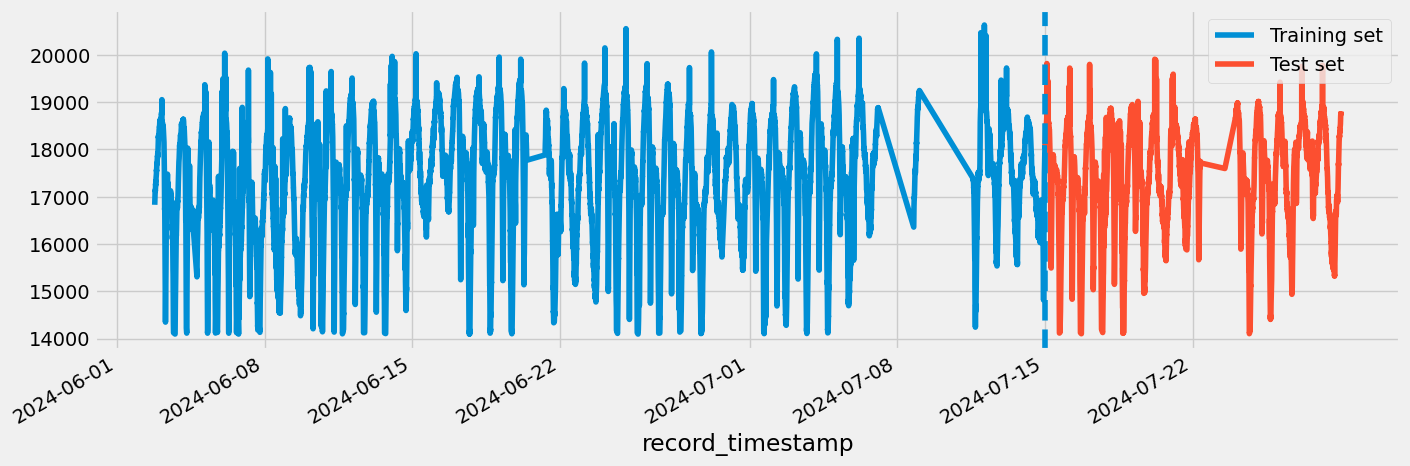

In [9]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='training set')
test.plot(ax=ax, label='test set')
ax.axvline(cutoff_date, ls='--')
ax.legend(['Training set', 'Test set'])


### Time partitions

<Axes: xlabel='record_timestamp'>

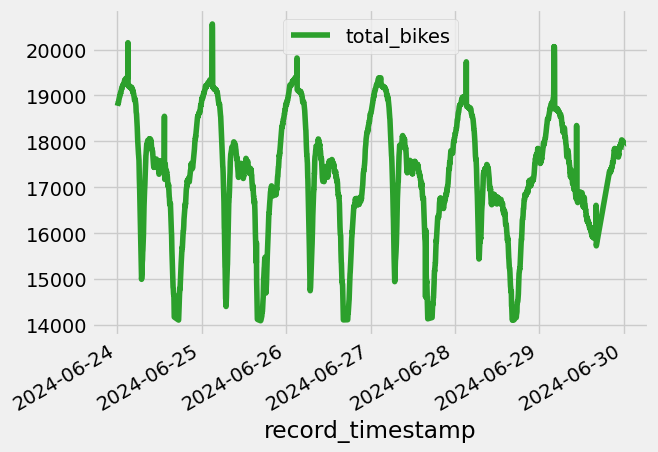

In [10]:
df.loc[(df.index > '2024-06-24') & (df.index < '2024-06-30')].plot(color=color_pal[2])

### Feature creation

In [11]:
def create_features(df):
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear
    df['minuteofday'] = df['hour'] * 60 + df['minute']
    df['quarterhourofday'] = (df['hour'] * 4) + (df['minute'] // 15)
    return df

df = create_features(df)

/tmp/ipykernel_2109977/3713477900.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax, data=df, x='hour', y='total_bikes', palette=color_pal)
/tmp/ipykernel_2109977/3713477900.py:3: UserWarning: 
The palette list has fewer values (10) than needed (24) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(ax=ax, data=df, x='hour', y='total_bikes', palette=color_pal)


Text(0.5, 1.0, 'bikes docked by hour')

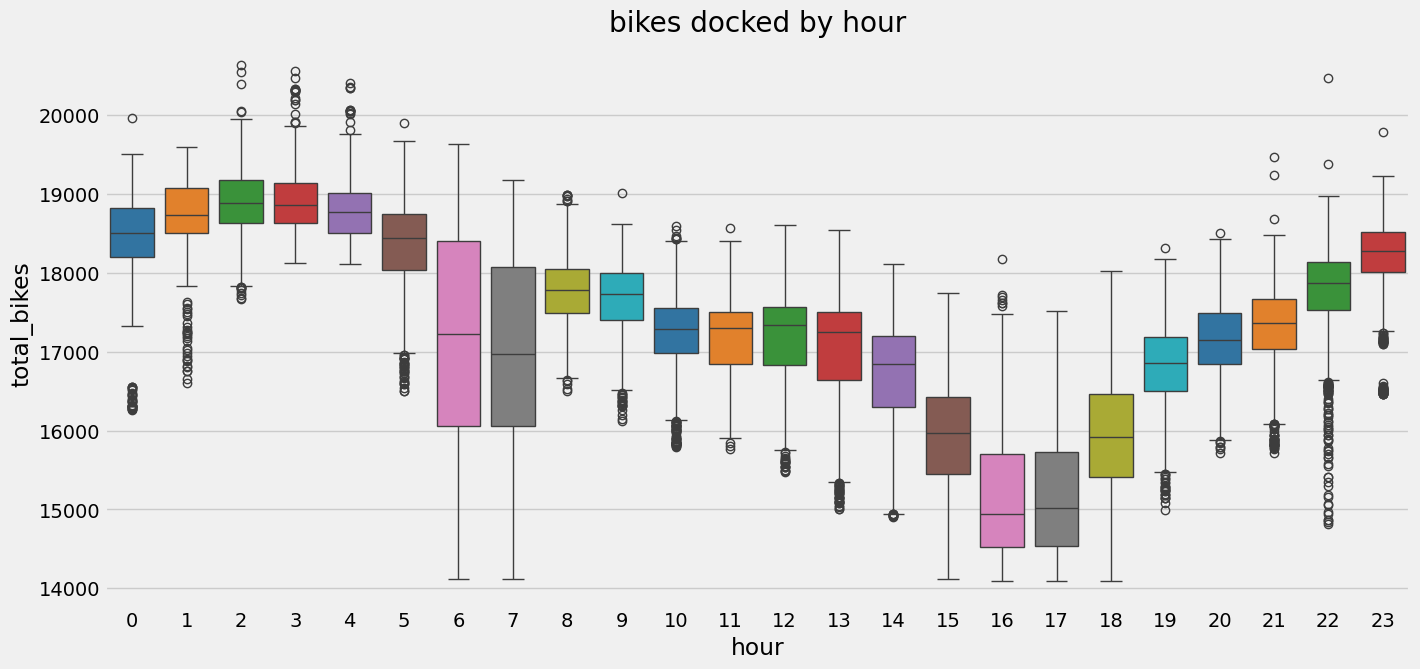

In [12]:
fig, ax = plt.subplots(figsize=(15, 7))

sns.boxplot(ax=ax, data=df, x='hour', y='total_bikes', palette=color_pal)
ax.set_title('bikes docked by hour')

/tmp/ipykernel_2109977/4003975902.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax, data=df, x='quarterhourofday', y='total_bikes', palette='Set2')


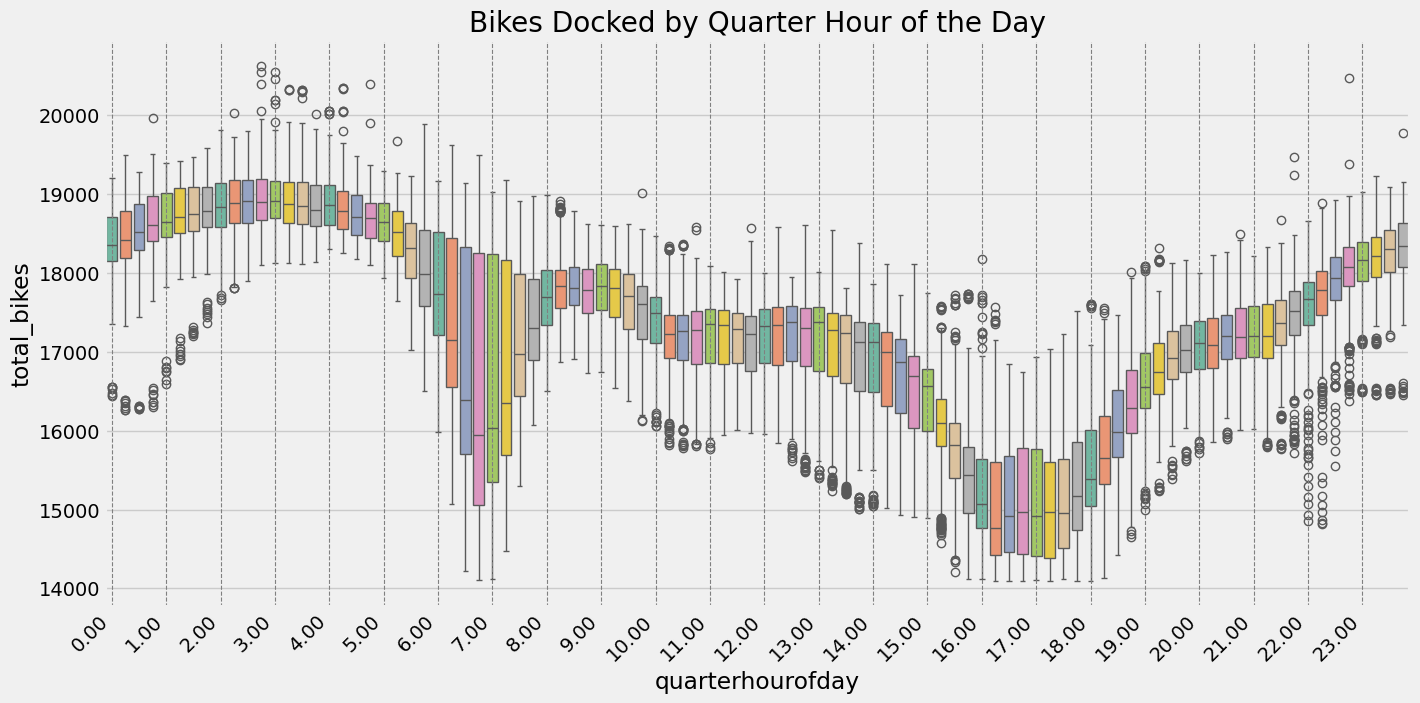

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(15, 7))

# Replace `color_pal` with your actual color palette
sns.boxplot(ax=ax, data=df, x='quarterhourofday', y='total_bikes', palette='Set2')

# Set title
ax.set_title('Bikes Docked by Quarter Hour of the Day')

# Add vertical lines at each new hour
for hour in range(24):
    quarterhour = hour * 4
    ax.axvline(x=quarterhour, color='gray', linestyle='--', linewidth=0.8)

# Adjust x-axis labels to show only whole hours
xticks = ax.get_xticks()
xticklabels = [f'{int(tick // 4)}.00' if tick % 4 == 0 else '' for tick in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=45, ha='right')

plt.show()


In [45]:
# separation feat / target

FEATURES = ['hour', 'dayofweek', 'month', 'dayofyear']
TARGET = 'total_bikes'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]


/tmp/ipykernel_2109977/1355863848.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax, data=df, y='quarterhourofday', x='total_bikes', palette='Set2', orient='h')


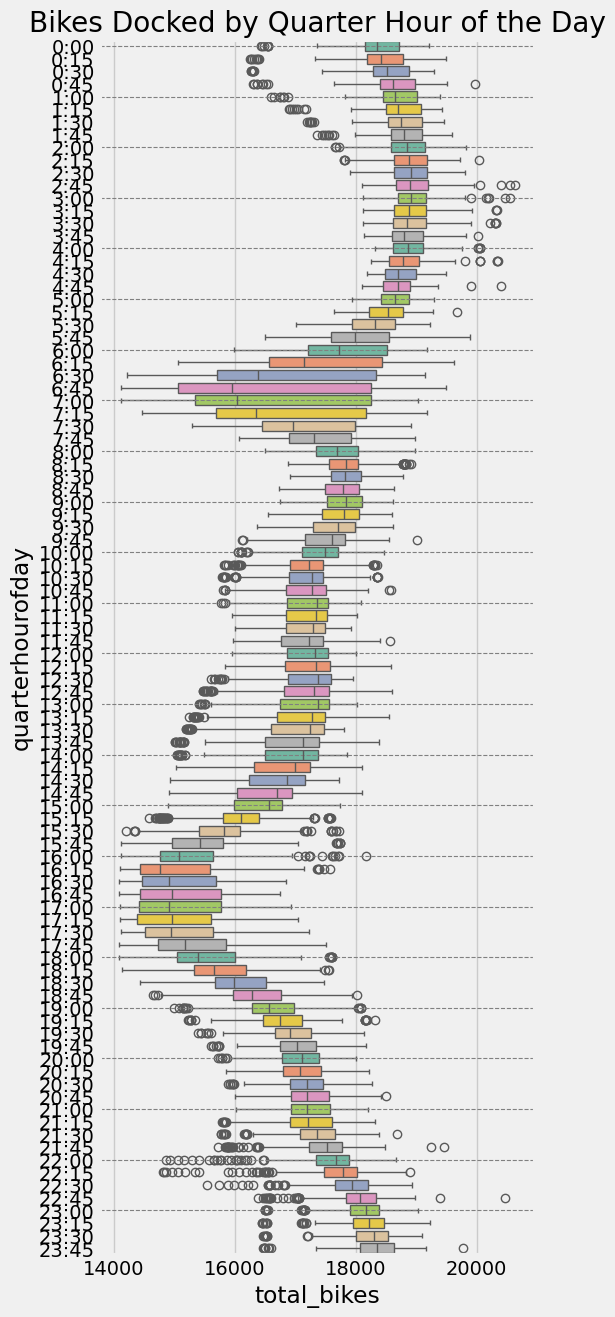

In [40]:
fig, ax = plt.subplots(figsize=(5, 15))

# Plot horizontal boxplot (vertical orientation of boxplots)
sns.boxplot(ax=ax, data=df, y='quarterhourofday', x='total_bikes', palette='Set2', orient='h')

# Set title
ax.set_title('Bikes Docked by Quarter Hour of the Day')

# Add vertical lines at each new hour
for hour in range(24):
    quarterhour = hour * 4
    ax.axhline(y=quarterhour, color='gray', linestyle='--', linewidth=0.8)

# Adjust y-axis labels
yticks = ax.get_yticks()
yticklabels = [f'{hour // 4}:{(hour % 4) * 15:02d}' for hour in yticks]
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels, rotation=0, ha='right')

plt.show()

/tmp/ipykernel_2109977/1071777296.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax, data=df, x='dayofweek', y='total_bikes', palette=color_pal)
/tmp/ipykernel_2109977/1071777296.py:3: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.boxplot(ax=ax, data=df, x='dayofweek', y='total_bikes', palette=color_pal)


Text(0.5, 1.0, 'bikes docked by day of the week')

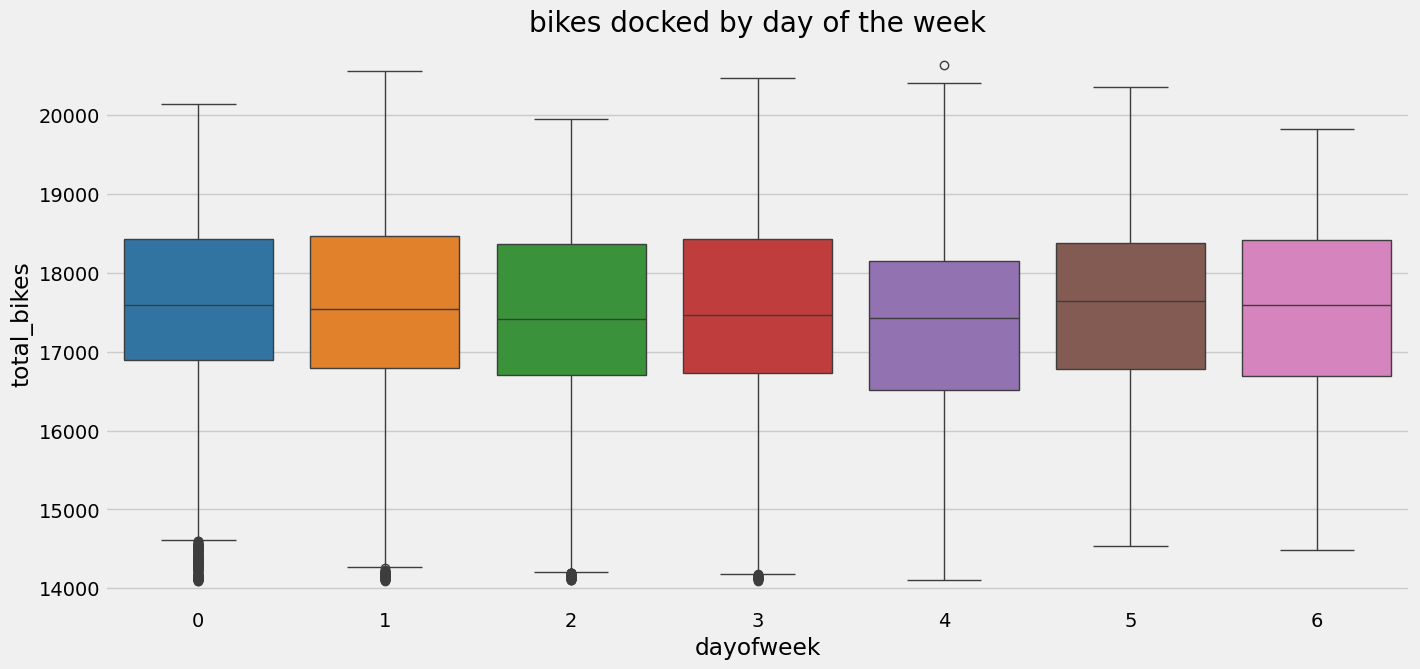

In [13]:
fig, ax = plt.subplots(figsize=(15, 7))

sns.boxplot(ax=ax, data=df, x='dayofweek', y='total_bikes', palette=color_pal)
ax.set_title('bikes docked by day of the week')

/tmp/ipykernel_2109977/1661873231.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax, data=df, x='month', y='total_bikes', palette=color_pal)
/tmp/ipykernel_2109977/1661873231.py:3: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.boxplot(ax=ax, data=df, x='month', y='total_bikes', palette=color_pal)


Text(0.5, 1.0, 'bikes docked by month')

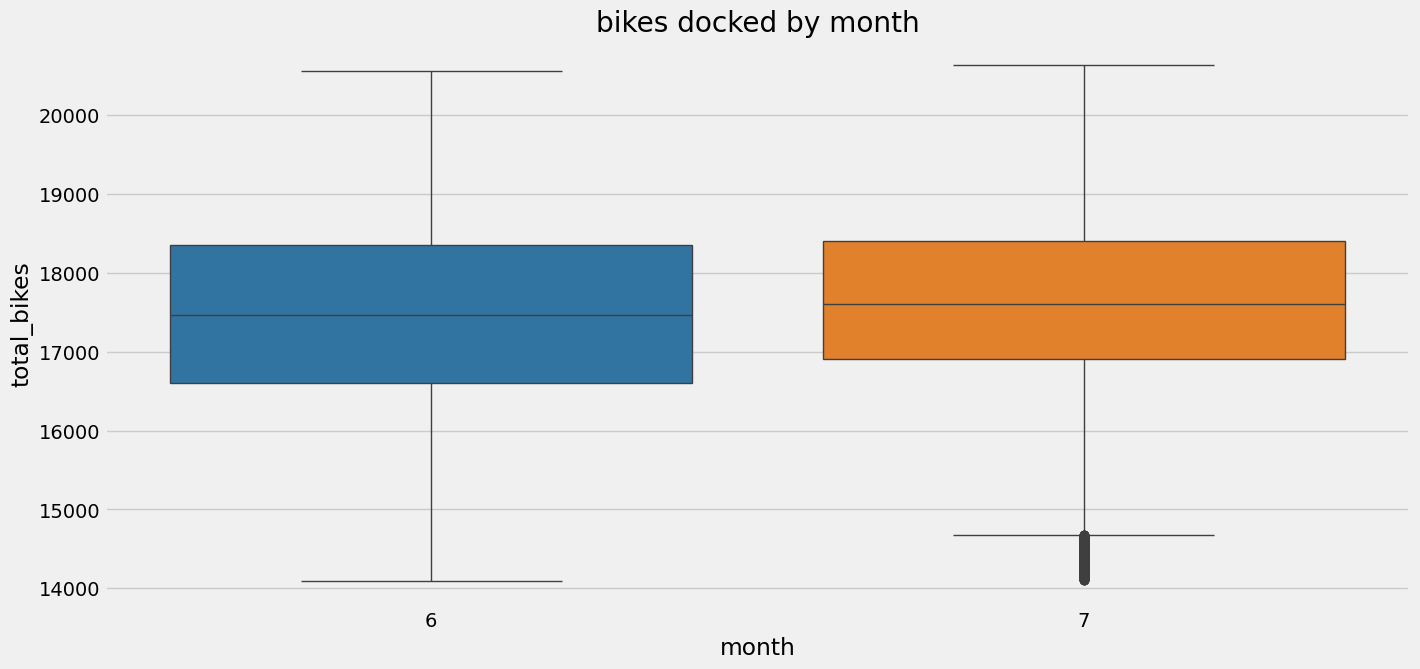

In [14]:
fig, ax = plt.subplots(figsize=(15, 7))

sns.boxplot(ax=ax, data=df, x='month', y='total_bikes', palette=color_pal)
ax.set_title('bikes docked by month')

## The model

In [15]:
# separatiodf.isna().sum()eate_features(train)
train = create_features(train)
test = create_features(test)


FEATURES = ['minuteofday', 'hour', 'dayofweek', 'month']
TARGET = 'total_bikes'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]


In [16]:
df.isna().sum()

total_bikes         0
hour                0
minute              0
dayofweek           0
month               0
dayofyear           0
minuteofday         0
quarterhourofday    0
dtype: int64

In [17]:
y_train.isna().sum()

np.int64(0)

In [18]:


reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50)

reg.fit(
        X_train, 
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=10
)

[0]	validation_0-rmse:958.21647	validation_1-rmse:777.77482
[10]	validation_0-rmse:447.91511	validation_1-rmse:453.63224
[20]	validation_0-rmse:432.08393	validation_1-rmse:483.72514
[30]	validation_0-rmse:428.65466	validation_1-rmse:494.55800
[40]	validation_0-rmse:426.34525	validation_1-rmse:505.45368
[50]	validation_0-rmse:425.14375	validation_1-rmse:510.90828
[54]	validation_0-rmse:424.78041	validation_1-rmse:512.31140


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [19]:
fi = pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_, columns=['importance'])
fi

,importance
minuteofday,0.775360
hour,0.015205
dayofweek,0.143914
month,0.065521


<Axes: title={'center': 'Feature importance'}>

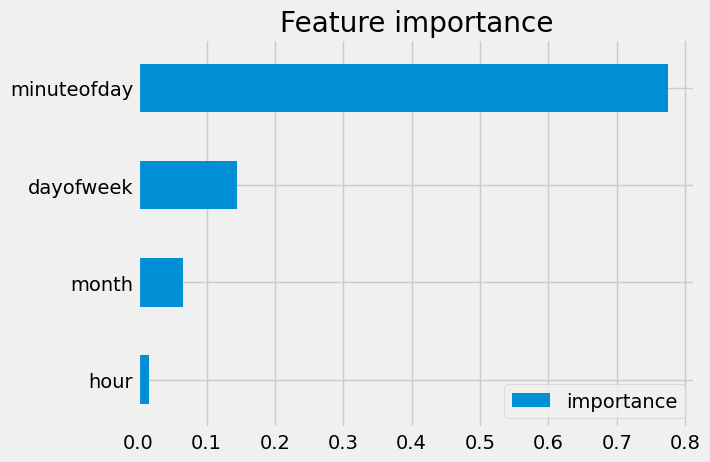

In [20]:
fi.sort_values('importance').plot(kind='barh', title='Feature importance')

### Forecasting

In [21]:
test['prediction'] = reg.predict(X_test)

In [22]:
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)



Text(0.5, 1.0, 'Raw data and predictions')

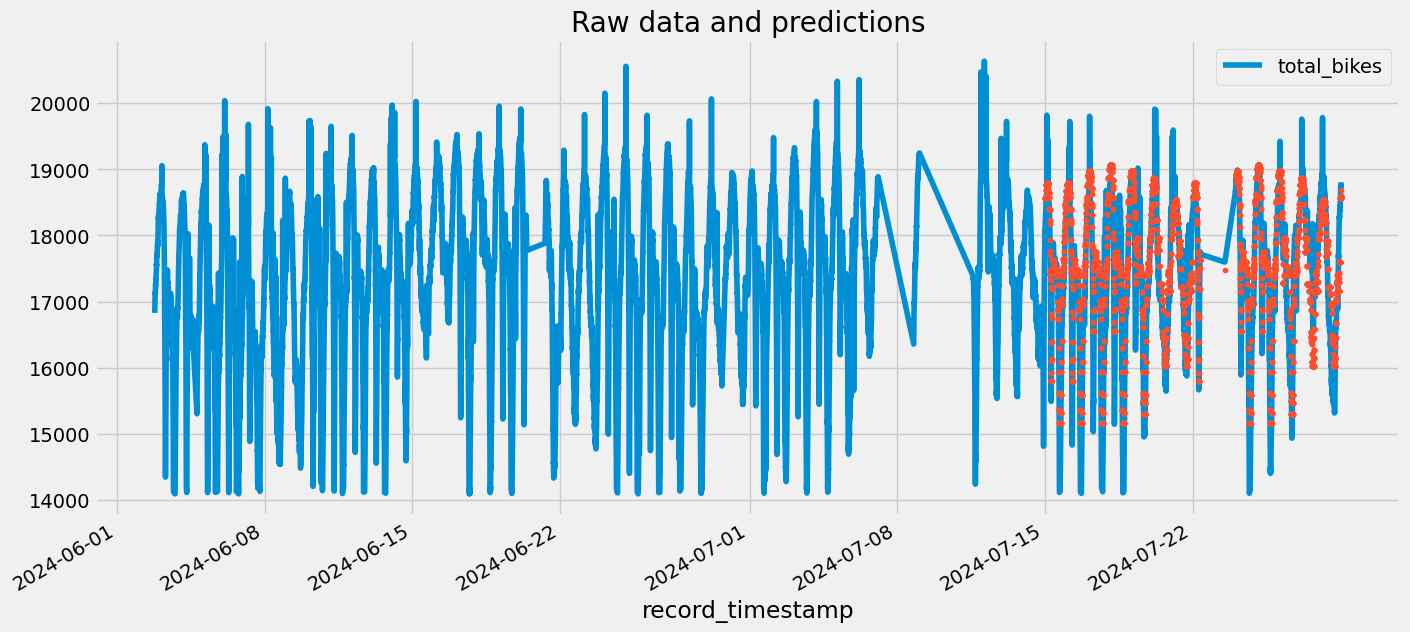

In [24]:

ax = df[['total_bikes']].plot(figsize=(15, 7))
df['prediction'].plot(ax=ax, style='.')
ax.set_title('Raw data and predictions')

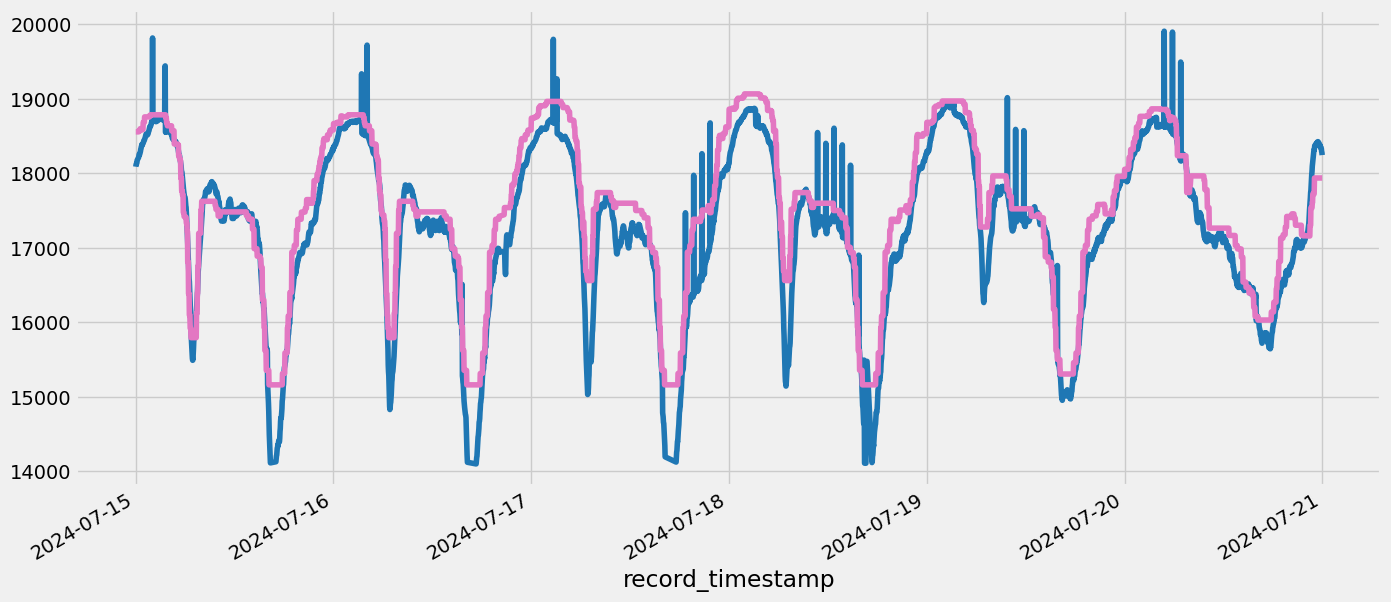

In [33]:
ax = df.loc[(df.index > '2024-07-15') & (df.index < '2024-07-21'), 'total_bikes'].plot(color=color_pal[0], figsize=(15,7))
ax = df.loc[(df.index > '2024-07-15') & (df.index < '2024-07-21'), 'prediction'].plot(color=color_pal[6])